The purpose of this notebook is to show how frequently the specific humidity ML limiter is active in prognostic runs. It also parses and shows the global mean statistics computed online in the prognostic runs.

Main conclusions:
- the limiter is active at roughly 10-20% of grid cells for vertical levels in the mid to upper troposphere
- more active (up to 30%) for rf-dQ1-dQ2-only run, which has a stronger dry bias in NH high latitudes (see zonal mean climatology notebook)
- limiter most active around vertical level 25 (roughtly 180mb), but also is also active down to level 45 (~500mb)
- it takes a couple weeks for the limiter to start being active at these frequencies
- most active in southern hemisphere winter

In [1]:
import xarray as xr
import fsspec
import yaml
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [2]:
urls = {
    'rf-control': 'gs://vcm-ml-experiments/2020-10-30-nudge-to-obs-GRL-paper/rf-control/prognostic_run',
    'rf-dQ1-dQ2-only': 'gs://vcm-ml-experiments/2020-10-30-nudge-to-obs-GRL-paper/rf-dQ1-dQ2-only/prognostic_run',
}
fs = fsspec.filesystem('gs')
limiter_prefix = b'INFO:root:specific_humidity_limiter_updates_per_level: '
statistics_prefix = b'INFO:statistics:'
logs_filename = 'logs.txt'

In [3]:
def process(line, prefix):
    # can't use json.loads because the limiter logs don't use quotes around keys
    return yaml.load(line[len(prefix):])

In [4]:
url = urls['rf-control']
stats = []
limit = []
for run, url in urls.items():
    print(f"Processing logs for {run}")
    artifacts_dirs = fs.ls(os.path.join(url, 'artifacts'))
    run_stats = []
    run_limit = []
    for dir_ in artifacts_dirs:
        print(f"Processing {os.path.split(dir_)[1]} segment")
        with fs.open(os.path.join(dir_, logs_filename)) as f:
            segment_logs = f.read().splitlines()
            limiter = [process(line, limiter_prefix) for line in segment_logs if limiter_prefix in line]
            statistics = [process(line, statistics_prefix) for line in segment_logs if statistics_prefix in line]
            statistics = statistics[::2]  # for some reason they are output twice per timestep

        statistics_ds = [xr.Dataset(s).expand_dims('time').set_coords('time') for s in statistics]
        statistics_ds = xr.concat(statistics_ds, 'time')
        statistics_ds['time'] = pd.to_datetime(statistics_ds.time.values)

        limiter_count_arr = np.zeros((len(limiter), len(limiter[0])))
        for t, timestep in enumerate(limiter):
            limiter_count_arr[t, :] = list(timestep.values())
        limiter_count = xr.DataArray(limiter_count_arr, dims=['time', 'z']) / (48 * 48 * 6) * 100
        limiter_count = limiter_count.assign_attrs(long_name='fraction of cells with humidity limiter active', units='%')
        limiter_count['time'] = statistics_ds.time

        run_stats.append(statistics_ds)
        run_limit.append(limiter_count)

    stats.append(xr.concat(run_stats, 'time').assign_coords(run=run))
    limit.append(xr.concat(run_limit, 'time').assign_coords(run=run))

stats = xr.concat(stats, 'run')
limit = xr.concat(limit, 'run')

Processing logs for rf-control
Processing 20160101.000000 segment


/home/OliWM/miniconda3/envs/fv3net/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


Processing 20160131.000000 segment
Processing 20160301.000000 segment
Processing 20160331.000000 segment
Processing 20160430.000000 segment
Processing 20160530.000000 segment
Processing 20160629.000000 segment
Processing 20160729.000000 segment
Processing 20160828.000000 segment
Processing 20160927.000000 segment
Processing 20161027.000000 segment
Processing 20161126.000000 segment
Processing logs for rf-dQ1-dQ2-only
Processing 20160101.000000 segment
Processing 20160131.000000 segment
Processing 20160301.000000 segment
Processing 20160331.000000 segment
Processing 20160430.000000 segment
Processing 20160530.000000 segment
Processing 20160629.000000 segment
Processing 20160729.000000 segment
Processing 20160828.000000 segment
Processing 20160927.000000 segment
Processing 20161027.000000 segment
Processing 20161126.000000 segment


#### Plot fraction of grid cells with ML humidity limiter active

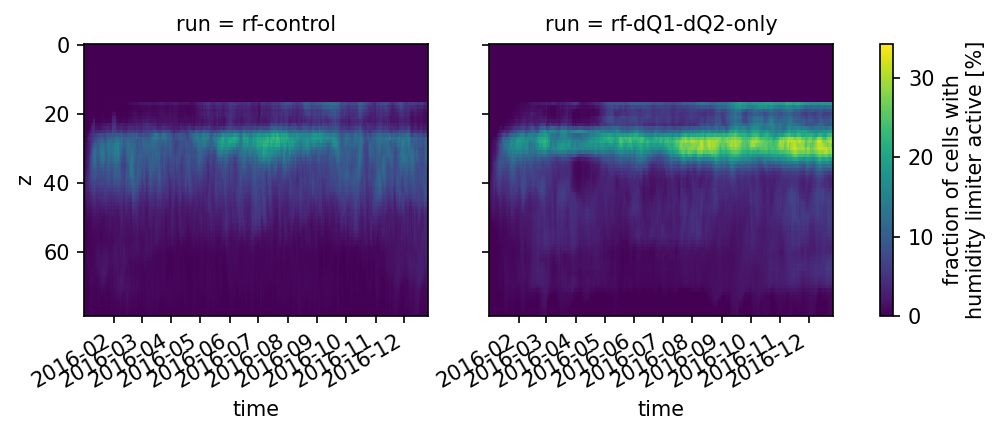

In [5]:
limit.plot(x='time', yincrease=False, col='run')

#### Zoom in on first 40-days of the simulations (neural network run was only 40 days long)

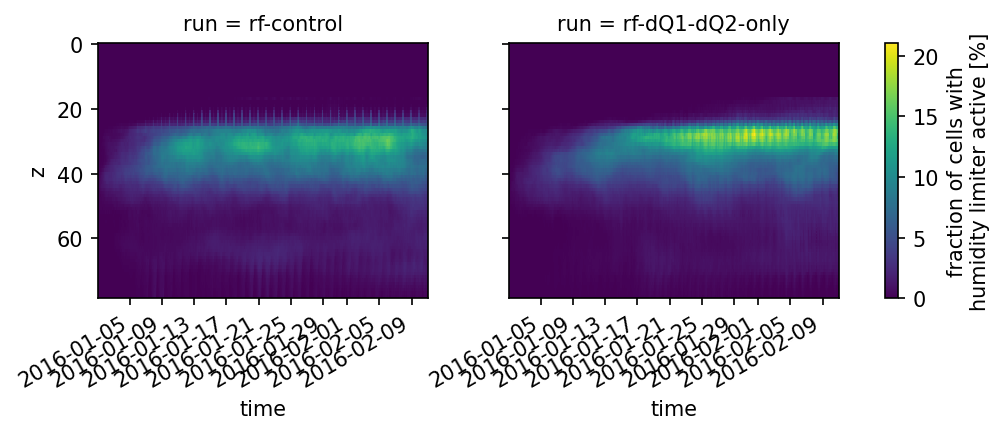

In [6]:
limit.sel(time=slice('2016-01', '2016-02-10')).plot(x='time', yincrease=False, col='run')

### Plot time average

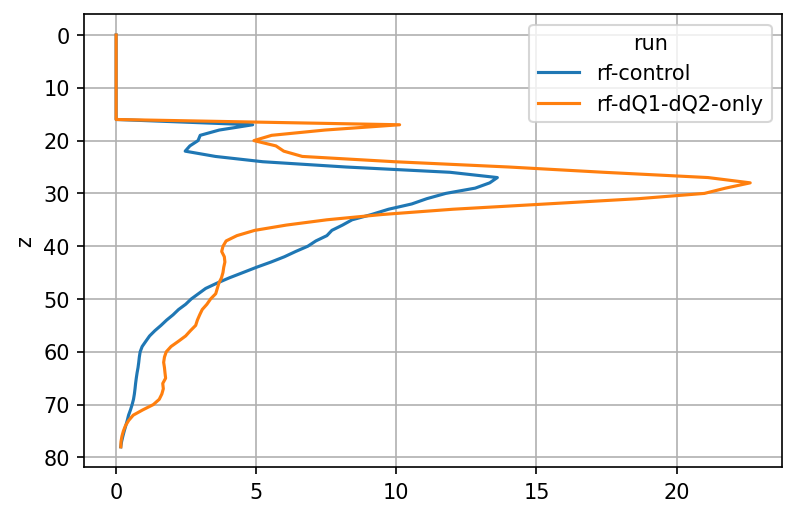

In [7]:
limit.mean('time').plot(y='z', yincrease=False, hue='run')
plt.grid()